In [87]:
import numpy as np
import sklearn

data = sklearn.datasets.load_diabetes()

X = data.data
y = data.target
#10 features

In [88]:
import lightgbm as lgb

from sklearn.model_selection import train_test_split

feature_importances = np.zeros(X.shape[1])

# Create the model with several hyperparameters
model = lgb.LGBMRegressor( boosting_type = 'goss', n_estimators = 10000, class_weight = 'balanced')

In [89]:
# Fit the model twice to avoid overfitting
for i in range(3):
    
    # Split into training and validation set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = i)
    
    # Train using early stopping
    model.fit(X_train, y_train, early_stopping_rounds=100, eval_set = [(X_test, y_test)], 
              eval_metric = 'auc', verbose = 2000)
feature_importances += model.feature_importances_
    # Record the feature importances

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[1]	valid_0's auc: 1	valid_0's l2: 4586.98
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[1]	valid_0's auc: 1	valid_0's l2: 5025.97
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[1]	valid_0's auc: 1	valid_0's l2: 4842.26


In [90]:
import pandas as pd
feature_importances = feature_importances / 3
feature_importances = pd.DataFrame({'feature': list(pd.DataFrame(X).columns), 'importance': feature_importances}).sort_values('importance', ascending = False)

feature_importances.head()

,feature,importance
2,2,1.333333
4,4,1.000000
8,8,0.666667
3,3,0.333333
6,6,0.333333


In [91]:
import matplotlib.pyplot as plt

def plot_feature_importances(df, threshold = 0.9):

    """
    Plots 15 most important features and the cumulative importance of features.
    Prints the number of features needed to reach threshold cumulative importance.
    
    Parameters
    --------
    df : dataframe
        Dataframe of feature importances. Columns must be feature and importance
    threshold : float, default = 0.9
        Threshold for prining information about cumulative importances
        
    Return
    --------
    df : dataframe
        Dataframe ordered by feature importances with a normalized column (sums to 1)
        and a cumulative importance column
    
    """
    
    plt.rcParams['font.size'] = 18
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    # Cumulative importance plot
    plt.figure(figsize = (8, 6))
    plt.plot(list(range(len(df))), df['cumulative_importance'], 'r-')
    plt.xlabel('Number of Features'); plt.ylabel('Cumulative Importance'); 
    plt.title('Cumulative Feature Importance');
    plt.show();
    
    importance_index = np.min(np.where(df['cumulative_importance'] > threshold))
    print('%d features required for %0.2f of cumulative importance' % (importance_index + 1, threshold))
    
    return df

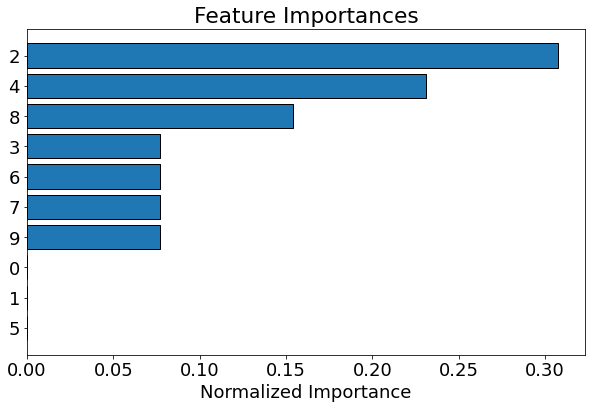

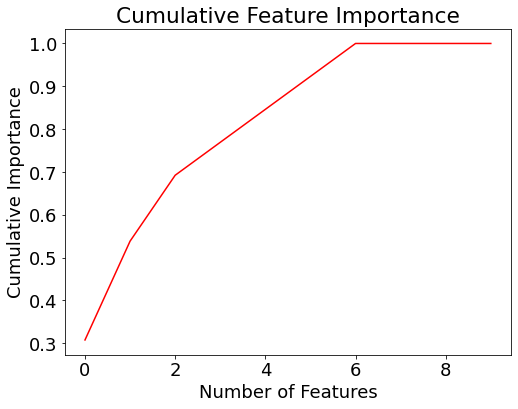

6 features required for 0.90 of cumulative importance


In [92]:
norm_feature_importances = plot_feature_importances(feature_importances)

In [93]:
zero_features = list(feature_importances[feature_importances['importance'] <= 0.20]['feature'])
print('There are %d features meaningful' % len(zero_features))
zero_features

There are 3 features meaningful


[0, 1, 5]

In [94]:
X_train = pd.DataFrame(X_train).drop(columns = zero_features)
X_test = pd.DataFrame(X_test).drop(columns = zero_features)




In [95]:
print (X_train)

            2         3         4         6         7         8         9
0   -0.055785 -0.036656  0.089244  0.008142  0.034309  0.132373  0.003064
1    0.104809  0.070073 -0.035968 -0.024993 -0.002592  0.003712  0.040343
2    0.017506 -0.022885  0.060349  0.030232 -0.002592  0.037232 -0.001078
3   -0.030996 -0.022885 -0.063487  0.019187 -0.039493 -0.096433 -0.034215
4   -0.040696 -0.015999 -0.008449  0.052322 -0.039493 -0.030751  0.003064
..        ...       ...       ...       ...       ...       ...       ...
326 -0.013751 -0.015999 -0.035968 -0.013948 -0.002592 -0.025952 -0.001078
327 -0.004050 -0.009113 -0.002945  0.022869 -0.039493 -0.061177 -0.013504
328 -0.004050 -0.012556  0.103003  0.056003 -0.002592  0.084495 -0.017646
329 -0.018062  0.080401  0.089244 -0.039719  0.108111  0.036056 -0.042499
330  0.059541 -0.002228  0.061725 -0.058127  0.108111  0.068982  0.127328

[331 rows x 7 columns]


In [97]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

regr = LinearRegression()
regr.fit(X_train, y_train)

y_hat = regr.predict(X_test)

print ("[TEST] R2 SCORE %.5f"%r2_score(y_test, y_hat))
print ("[TEST] MSE SCORE %.5f"%mean_squared_error(y_hat, y_test))

[TEST] R2 SCORE 0.40943
[TEST] MSE SCORE 3109.67899
